In [1]:
import numpy as np
import pandas as pd
import scipy

from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('hw7_data.csv')
data = data.set_index('date')

In [3]:
asset_cols = ['gm', 'adbe', 'ora', 'flo']
factor_cols = ['mkt_rf', 'smb', 'hml']
rf_col = ['rf']

In [4]:
f = data[factor_cols]
r = data[asset_cols]
rfr = data[rf_col]
# subtract rfr from returns based on FFC formula
r_e = r.subtract(rfr.values)
x = f.copy(deep=True)
# add col of ones to F
f.loc[:, 'intercept'] = 1
f = f[['intercept'] + factor_cols]

C:\Users\yrevtsov\AppData\Local\Temp\ipykernel_40740\3028590262.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f.loc[:, 'intercept'] = 1


In [5]:
b = np.linalg.inv(f.T @ f) @ f.T @ r_e
b.index = f.columns

In [6]:
e = r - f @ b

In [7]:
(f @ b + e - r).abs().sum()

gm      8.673617e-17
adbe    1.008308e-16
ora     8.977194e-17
flo     9.844556e-17
dtype: float64

### Q 1.1

In [8]:
b

,gm,adbe,ora,flo
intercept,-0.002409,0.008293,0.010312,0.004895
mkt_rf,1.190780,1.201222,0.590398,0.480240
smb,0.729088,-0.253283,0.419412,-0.273027
hml,0.671768,-0.557792,-0.224427,0.256518


### Q 1.2

As seen below, correlations of residual returns are lower than that of excess returns. This aligns with intuition. Parts of returns that correlated should also be explained by the factors of the model. Therefore, the parts that are not explained by the factors are also less correlated.

##### excess return correlation

In [9]:
r_e.corr()

,gm,adbe,ora,flo
gm,1.000000,0.409751,0.379564,0.200341
adbe,0.409751,1.000000,0.163720,0.195851
ora,0.379564,0.163720,1.000000,0.169515
flo,0.200341,0.195851,0.169515,1.000000


##### residual return correlation

In [10]:
e.corr()

,gm,adbe,ora,flo
gm,1.000000,0.130282,0.238472,0.009456
adbe,0.130282,1.000000,-0.141852,0.051144
ora,0.238472,-0.141852,1.000000,0.109211
flo,0.009456,0.051144,0.109211,1.000000


### Q 1.3

In [11]:
sigma = r.cov()

mu = r.mean()

eigval, eigvec = scipy.linalg.eig(sigma)

y = np.matmul((r - mu), eigvec.T)

# get top 2 eigen vectors
gamma = eigvec[:, 0:2]

# get top 2 PCs
e_pca = r - (y[[0, 1]] @ gamma.T + mu.values).values

##### mean (mu)

In [12]:
mu

gm      0.008983
adbe    0.020731
ora     0.016583
flo     0.009865
dtype: float64

##### gamma (eigenvectors/principal components)

In [13]:
gamma

array([[ 0.71899768,  0.55471646],
       [ 0.42234415, -0.69509997],
       [ 0.49612657, -0.35359037],
       [ 0.24192184,  0.28999919]])

##### covariance matrix of error term

In [14]:
e_pca.cov()

,gm,adbe,ora,flo
gm,0.001402,-0.000420,-0.001406,-0.001692
adbe,-0.000420,0.001125,-0.001365,0.001260
ora,-0.001406,-0.001365,0.004860,0.000133
flo,-0.001692,0.001260,0.000133,0.003050


### Q 1.4

As seen below, there's a -.75 correlation between the first principal component and market return. The scatter plot also shows a linear relationship. At first this seemed unintuitive to me as I expected a positive correlation. However, taking the eigen vectors and regression coefficients into account, the results make more sense. The first eigen vector is negative while the market factor coefficients from the regression are positive. 

Even though principal components do not have direct real-world explanations, this analysis shows that the first principal components can be thought of a market exposure of the assets.

In [15]:
# create df from the first PC and market factor + risk free rate
mkt = y[0].rename('First PC').to_frame().join((f.mkt_rf + rfr.squeeze()).rename('Market'), how='inner')

In [16]:
mkt.corr()

,First PC,Market
First PC,1.000000,0.773353
Market,0.773353,1.000000


<Axes: title={'center': 'First PC vs Market'}, xlabel='First PC', ylabel='Market'>

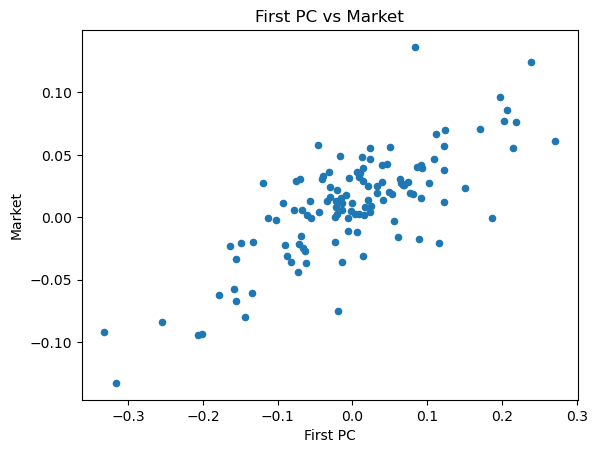

In [17]:
mkt.plot.scatter(x='First PC', y='Market', title='First PC vs Market')

### Q 1.5

Principal components are uncorrelated by definition of the transformation. The residuals are made up of the remaining principal components. Therefore, the residuals will be uncorrelated with other principal components. This is empirically shown below.

In [18]:
e_pca.join(y, how='inner').corr()[[0, 1]].round(10)

,0,1
gm,-0.094880,-0.316398
adbe,0.360774,0.019762
ora,-0.032065,0.355887
flo,-0.082955,0.335408
0,1.000000,0.142470
1,0.142470,1.000000
2,-0.013048,-0.051766
3,-0.114979,-0.122577
